***pairwise_distance.ipynb***

Determine the positions of $N$ points in $D$-dimensional space as to minimize the ratio of pairwise distances between points, that is, minimize the ratio of *min* and *max* squared distances.

&copy; Copyright 2025 Fair Isaac Corporation

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0.
 
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This example uses FICO&reg; Xpress software. By running it, you agree to the Community License terms of the [Xpress Shrinkwrap License Agreement](https://www.fico.com/en/shrinkwrap-license-agreement-fico-xpress-optimization-suite-on-premises) with respect to the FICO&reg; Xpress software. See the [licensing options](https://www.fico.com/en/fico-xpress-trial-and-licensing-options) overview for additional details and information about obtaining a paid license.

In [ ]:
# Install the xpress package
%pip install -q xpress matplotlib plotly

## Problem description and formulation

This optimization problem determines the positions of **$N$** points in a **$D$**-dimensional space such that the ratio of the maximum to minimum squared pairwise distances is minimized, which is addressed by **maximizing the minimum distance** in our formulation. This promotes a uniform distribution of points, minimizing clustering and maximizing spatial efficiency.

The **decision variables** are defined below, with $\mathcal{N}$ and $\mathcal{D}$ being the corresponding sets of points and dimensions, respectively:
- $x_{i,k}$: Coordinate of point $i \in \mathcal{N}$ in dimension $k \in \mathcal{D}$
- $t_{\min}$: Minimum squared distance between any two points
- $t_{\max}$: Maximum squared distance between any two points (fixed to 1)
- $r$: Ratio variable, defined as $r = \frac{1}{t_{\min}}$

For all pairs of points $i,j \in \mathcal{N}$ where $i < j$, the squared Euclidean distance is **constrained** as:

$$ \sum_{k \in \mathcal{D}} (x_{i,k} - x_{j,k})^2 \geq t_{\min}, \qquad \forall i, j \in \mathcal{N}, i < j $$
$$ \sum_{k \in \mathcal{D}} (x_{i,k} - x_{j,k})^2 \leq 1, \qquad \forall i, j \in \mathcal{N}, i < j $$

Additionally, we define the ratio variable by adding the constraint $r \cdot t_{\min} = 1$. Since the problem is *scale-invariant*, that is, the outcome of the problem does not change when all lengths are multiplied by the same constant factor, for simplicity we fix $t_{\max} = 1$.

The **objective function** is to maximize the minimum squared distance: $\max t_{\min}$. This is equivalent to minimizing the ratio $\frac{t_{\max}}{t_{\min}}$, since $t_{\max}$ is fixed to 1. This reformulates the problem as a quadratic problem that can be handled by a specific solver (Xpress-SLP) instead of the generic Global solver.  The optimization is subject to a time limit defined by `LIMIT`.

The result is a configuration of $N$ points in $D$-dimensional space that are as evenly spaced as possible, minimizing the ratio of largest to smallest pairwise distances.


## Model implementation

The previous model is implemented below for the 3D case, with a time limit of 10 seconds for the solver. You can also work on the 2D space, and experiment with different numbers of points and increase or decrease the solver [time limit](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/HTML/TIMELIMIT.html). A lower bound of 0.1 is defined for $t_{min}$ to ensure that points are sufficiently far from each other, giving a maximum ratio of approximately $10$ for $N = 12$ points.

After the optimization, the objective (ratio) and solution values are printed following the solver logs (ON by default).

In [ ]:
import xpress as xp
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio

N = 12          # Number of points to be placed.
D = 3           # Number of dimensions: 3 for 3D, 2 for 2D.
LIMIT = 5       # Time limit for the solver.

POINTS = range(N)  # Points to be placed.
DIMS = range(D)    # Dimensions.

# Create a problem instance.
p = xp.problem()

# Decision variables.
x = p.addVariables(POINTS, DIMS, ub=1, name="x")  # N points in d-dimensional space
t_min = p.addVariable(lb=0.1, name="t_min")       # Minimum squared distance variable.
t_max = p.addVariable(name="t_max")               # Maximum squared distance variable.
r = p.addVariable(name="r")                       # Ratio variable.

# Constraints to ensure that the points are placed in a way that
# the minimum distance between any two points is t_min and the maximum is 1
p.addConstraint(xp.Sum((x[i,k] - x[j,k])**2 for k in DIMS) >= t_min for i in POINTS for j in POINTS if i < j)
p.addConstraint(xp.Sum((x[i,k] - x[j,k])**2 for k in DIMS) <= 1 for i in POINTS for j in POINTS if i < j)

# We wish to minimize t_max/t_min, which is invariant for scaling. We can 
# thus narrow the search to configurations where t_max is 1
p.addConstraint(t_max == 1)
# Compute ratio
p.addConstraint(r * t_min == 1)

# Objective: minimize the square root of ratio t_max / t_min.
# Instead of minimizing r=1/t_min, we can improve the formulation by
# maximizing t_min.
p.setObjective(t_min, sense=xp.maximize)

# Set the solver parameters.
p.controls.timelimit = LIMIT

# Solve the problem.
p.optimize()

# Print the solution
status = p.attributes.solstatus
if status in {xp.SolStatus.FEASIBLE, xp.SolStatus.OPTIMAL}:
    print("Solution value (ratio):", p.getSolution(r))
    print("t_max:", p.getSolution(t_max), ", t_min:", p.getSolution(t_min))
    xsol = p.getSolution(x)
    for i in POINTS:
        for j in DIMS:
            print(f"{x[i,j].name}: {xsol[i,j]}")
else:
    print(f"No solution found with time limit of {LIMIT} sec")


## Visualization

The code cell below generates a plot in either 2D or 3D (depending on the value of $D$ chosen above) using *matplotlib*. 

The plot containts the solution points, and the lines between any two points placed at the **minimum distance (blue)** or the **maximum distance (red)** amongst the whole set of pairwise distances.

N = 12, D = 3, Ratio = 3.903063633999093


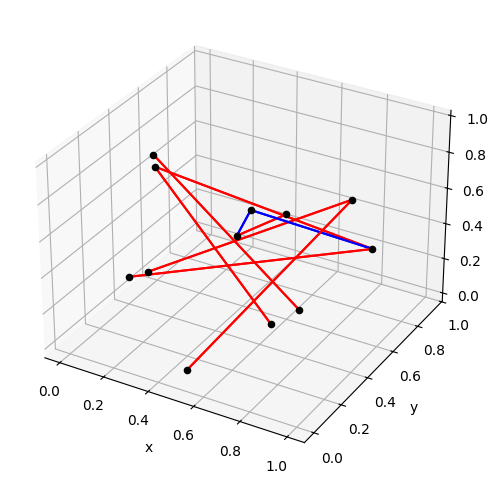

In [2]:
print(f"N = {N}, D = {D}, Ratio = {p.getSolution(r)}")

# Convert to dictionary with point ID as key and list of coordinates as value
points = {}
for (point_id, dimension), value in xsol.items():
    if point_id not in points:
        # Initialize list with None values up to the maximum dimension
        max_dim = max(d for _, d in xsol.keys()) + 1
        points[point_id] = [None] * max_dim
    points[point_id][dimension] = value

# Calculate squared distance
def squared_distance(p1, p2, ndims):
    return  sum((p1[i] - p2[i])**2 for i in range(ndims))

# Create a plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d' if D == 3 else None)

# Plot points
for point in points.values():
    ax.scatter(*point, color='black')

# Draw lines with color based on distance
tol = p.controls.feastol
for i in points:
    for j in points:
        p1, p2 = points[i], points[j]
        dist = squared_distance(p1, p2, D)
        if dist - p.getSolution(t_min) <= tol:
            if D == 2:  # For 2D, we can plot in 2D space
                ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color='blue')
            else:       # For 3D, we plot in 3D space
                ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], color='blue')
        if 1 - dist <= tol: 
            if D == 2:
                ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color='red')
            else:
                ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], color='red')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z') if D == 3 else None

plt.show()

## Interactive 3D visualization

If you selected $D = 3$, then you can generate an **interactive 3D plot** of the same solution with the code cell below, which uses the *plotly* library. By default, the renderer is setup for Visual Studio Code, but you can adapt this to your own environment.

After rendering, you can do *orbital rotation of the plot in any direction* and see the solution from different angles, as well as observing the coordinates of each point when hovering over. An `HMTL` file named `interactive_plot.html` is also exported in case you prefer to explore it in a web browser.


In [3]:
# Set the default renderer for Plotly to 'vscode'
pio.renderers.default = 'vscode' # 'notebook', 'iframe', 'browser', ...

# Calculate squared distance
def squared_distance(p1, p2):
    return sum((p1[i] - p2[i])**2 for i in range(len(p1)))

# Create a 3D scatter plot
fig = go.Figure()

# Add points to the plot
for point in points.values():
    fig.add_trace(go.Scatter3d(
        x=[point[0]], y=[point[1]], z=[point[2]],
        mode='markers',
        marker=dict(color='black', size=5)
    ))

# Draw lines with color based on distance
tol = p.controls.feastol
for i in points:
    for j in points:
        if i != j:
            p1, p2 = points[i], points[j]
            dist = squared_distance(p1, p2)
            if dist - p.getSolution(t_min) <= tol:
                fig.add_trace(go.Scatter3d(
                    x=[p1[0], p2[0]], y=[p1[1], p2[1]], z=[p1[2], p2[2]],
                    mode='lines',
                    line=dict(color='blue')
                ))
            if 1 - dist <= tol:
                fig.add_trace(go.Scatter3d(
                    x=[p1[0], p2[0]], y=[p1[1], p2[1]], z=[p1[2], p2[2]],
                    mode='lines',
                    line=dict(color='red')
                ))

# Set axis labels
fig.update_layout(scene=dict(
    xaxis_title='x',
    yaxis_title='y',
    zaxis_title='z'),
    showlegend=False,   # Remove legend entries
    width=1000,         # Set figure width
    height=800          # Set figure height
)

# Save the plot as an HTML file
fig.write_html("interactive_plot.html")

# Show the plot
fig.show()
